In [1]:
import os
import sys
import json
import numpy as np

def iou(a, b):
    ax, ay, ar, ab = a
    bx, by, br, bb = b
    cross_x = max(ax, bx)
    cross_y = max(ay, by)
    cross_r = min(ar, br)
    cross_b = min(ab, bb)
    cross_w = max(0, (cross_r - cross_x) + 1)
    cross_h = max(0, (cross_b - cross_y) + 1)
    cross_area = cross_w * cross_h
    union = (ar - ax + 1) * (ab - ay + 1) + (br - bx + 1) * (bb - by + 1) - cross_area
    return cross_area / union

def nms(bboxes, threshold, confidence_index=-1):
    bboxes.sort(key=lambda x: x[confidence_index], reverse=True)
    flags = [True] * len(bboxes)
    keep = []
    for i in range(len(bboxes)):
        if not flags[i]: continue
        keep.append(bboxes[i])

        for j in range(i+1, len(bboxes)):
            if iou(bboxes[i][:4], bboxes[j][:4]) > threshold:
                flags[j] = False
    return keep

def nms_as_class(bboxes, threshold, class_index=-1, confidence_index=-2):
    boxasclass = {}
    for box in bboxes:
        classes = box[class_index]
        if classes not in boxasclass:
            boxasclass[classes] = []
        boxasclass[classes].append(box)

    output = []
    for key in boxasclass:
        result = nms(boxasclass[key], threshold, confidence_index)
        output.extend(result)
    return output

def xml_value(line):
    p0 = line.find(">") + 1
    p1 = line.find("</", p0)
    return line[p0:p1]

def xml_token(line):
    p0 = line.find("<") + 1
    p1 = line.find(">", p0)
    return line[p0:p1]

def load_voc_xml(file):

    with open(file, "r") as f:
        lines = f.readlines()

    name = None
    box = None
    bboxes = []
    enter_object = False
    enter_part = False
    for line in lines:
        token = xml_token(line)

        if token == "object":
            enter_object = True
        elif token == "/object":
            enter_object = False
        elif enter_object:
            if token == "part":
                enter_part = True
            elif token == "/part":
                enter_part = False

            if not enter_part:
                if token == "name":
                    name = xml_value(line)
                elif token == "bndbox":
                    box = [name]
                    bboxes.append(box)
                elif token in ["xmin", "ymin", "xmax", "ymax"]:
                    box.append(float(xml_value(line)))
    return bboxes

def load_ann(root, call):
    files = os.listdir(root)
    anns = {}
    for file in files:
        name = file[:file.rfind(".")]
        anns[name] = call(os.path.join(root, file))
    return anns

def load_json_ann(root):
    def call(file):
        with open(file, "r") as f:
            ann = json.load(f)
        return ann
    return load_ann(root, call)

def load_xml_ann(root, label_map):
    def call(file):
        return [item[1:] + [0, label_map.index(item[0])] for item in load_voc_xml(file)]
    return load_ann(root, call)

In [2]:
detection_annotation_root = "predict_json"
groundtruth_annotation_root = "groundtruths_xml"
label_map = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
detection_annotations = load_json_ann(detection_annotation_root)
groundtruth_annotations = load_xml_ann(groundtruth_annotation_root, label_map)

for image_id in detection_annotations:
    image_base_annotations = detection_annotations[image_id]
    image_base_annotations = nms_as_class(image_base_annotations, 0.5)
    detection_annotations[image_id] = image_base_annotations

In [8]:
groundtruth_annotations

{'000001': [[48.0, 240.0, 195.0, 371.0, 0, 11],
  [8.0, 12.0, 352.0, 498.0, 0, 14]],
 '000002': [[139.0, 200.0, 207.0, 301.0, 0, 18]],
 '000003': [[123.0, 155.0, 215.0, 195.0, 0, 17],
  [239.0, 156.0, 307.0, 205.0, 0, 8]],
 '000004': [[13.0, 311.0, 84.0, 362.0, 0, 6],
  [362.0, 330.0, 500.0, 389.0, 0, 6],
  [235.0, 328.0, 334.0, 375.0, 0, 6],
  [175.0, 327.0, 252.0, 364.0, 0, 6],
  [139.0, 320.0, 189.0, 359.0, 0, 6],
  [108.0, 325.0, 150.0, 353.0, 0, 6],
  [84.0, 323.0, 121.0, 350.0, 0, 6]],
 '000006': [[187.0, 135.0, 282.0, 242.0, 0, 15],
  [154.0, 209.0, 369.0, 375.0, 0, 10],
  [255.0, 207.0, 366.0, 375.0, 0, 8],
  [298.0, 195.0, 332.0, 247.0, 0, 8],
  [279.0, 190.0, 308.0, 231.0, 0, 8],
  [137.0, 192.0, 151.0, 199.0, 0, 8],
  [137.0, 198.0, 156.0, 212.0, 0, 8],
  [138.0, 211.0, 249.0, 375.0, 0, 8]],
 '000008': [[192.0, 16.0, 364.0, 249.0, 0, 8]],
 '000010': [[87.0, 97.0, 258.0, 427.0, 0, 12],
  [133.0, 72.0, 245.0, 284.0, 0, 14]],
 '000011': [[126.0, 51.0, 330.0, 308.0, 0, 7]],
 '00

detection_annotations  
groundtruth_annotations

是一个字典 格式为：  
{"image_name":[[x1,y1,x2,y2,conf,class_index],[x1,y1,x2,y2,conf,class_index]]}

In [45]:
select_index = list(detection_annotations.keys())[0]

In [57]:
detection_annotations[select_index],groundtruth_annotations[select_index]

([[41.20088454223368,
   19.315436482429504,
   347.54373109929605,
   496.85370922088623,
   0.8433715105056763,
   14.0],
  [-15.00376345085742,
   230.68836331367493,
   340.06859323347544,
   500.98860263824463,
   0.026317788287997246,
   11.0]],
 [[48.0, 240.0, 195.0, 371.0, 0, 11], [8.0, 12.0, 352.0, 498.0, 0, 14]])

选择一个类别进行计算ap

In [47]:
compute_classes_index = 0

In [71]:
def iou(a,b):
    '''
    a:4xMx1
    b:4x1xN
    --> 1xMxN
    '''
    aleft,atop,aright,abottom =[a[i] for i in range(4)]
    bleft,btop,bright,bbottom =[b[i] for i in range(4)]

    a_width = aright-aleft+1
    b_width = bright-bleft+1

    a_height = abottom-atop+1
    b_height = bbottom-btop+1

    c_left = np.maximum(aleft,bleft)
    c_top = np.maximum(atop,btop)

    c_right = np.minimum(aright,bright)
    c_bottom = np.minimum(abottom,bbottom)

    cross_area = (c_right - c_left + 1).clip(0) * (c_bottom - c_top + 1).clip(0)
    union_area = a_width * a_height + b_width * b_height - cross_area
    return cross_area/union_area


构建matched_table
- 每一行的格式是：[confidence, matched_iou, matched_groundtruth_index, image_id]
    - 行数是所有图像的指定类别（compute_classes_index）的detection数量总和
    - matched_groundtruth_index是当前detection的框，与其图像上所有同类别groundtruth框IoU最大的那个的索引
    - matched_iou则是与当前detection最匹配的matched_groundtruth_index的IoU

In [84]:
matched_table = []
sum_groundtruth = 0
max_dets = 100

for image_id in groundtruth_annotations:
    select_detection = np.array(list(filter(lambda x:x[-1]==compute_classes_index,detection_annotations[image_id])))
    select_groundtruth = np.array(list(filter(lambda x:x[-1]==compute_classes_index,groundtruth_annotations[image_id])))
    num_use_detection = min(len(select_detection),max_dets)
    sum_groundtruth+=len(select_groundtruth)
    if len(select_detection)==0:
        continue
    if len(select_groundtruth)==0:
        for index_of_detection in range(num_use_detection):
            confidence = select_detection[index_of_detection,4]
            matched_table.append([confidence,0,-1,image_id])
        continue
    sgt = select_groundtruth.T.reshape(6,-1,1)
    sdt = select_detection.T.reshape(6,1,-1)
    groundtruth_detection_iou = iou(sgt,sdt)##sgtxsdt
    for index_of_detection in range(num_use_detection):
        confidence =  select_detection[index_of_detection,4]
        matched_groundtruth_index = groundtruth_detection_iou[:,index_of_detection].argmax()
        matched_iou = groundtruth_detection_iou[matched_groundtruth_index,index_of_detection]
        matched_table.append([confidence,matched_iou,matched_groundtruth_index,image_id])
matched_table = sorted(matched_table,key=lambda x:x[0],reverse=True)

In [85]:
groundtruth_detection_iou

array([[0.54950394]])

In [86]:
matched_table[:5]

[[0.9423317909240723, 0.712588290494865, 0, '009329'],
 [0.9255480170249939, 0.8816558261119185, 0, '007403'],
 [0.9168242812156677, 0.9117074880579924, 0, '001126'],
 [0.9092625975608826, 0.9145634697725846, 0, '002908'],
 [0.9072845578193665, 0.8018974517723729, 0, '004680']]

In [87]:
iou_threshold = 0.5
num_dets = len(matched_table)
true_positive = np.zeros((num_dets,))

groundtruth_seen_map = {item[3]:set() for item in matched_table}
for index,(confidence,matched_iou,matched_groundtruth_index,image_id) in enumerate(matched_table):
    image_base_seen_map = groundtruth_seen_map[image_id]
    if matched_iou>=iou_threshold:
        if matched_groundtruth_index not in image_base_seen_map:
            true_positive[index] = 1
            image_base_seen_map.add(matched_groundtruth_index)
num_predicts = np.arange(1,len(true_positive)+1)
accumulate_true_positive = np.cumsum(true_positive)
precision = accumulate_true_positive/num_predicts
recall = accumulate_true_positive/sum_groundtruth

In [88]:
sum_groundtruth

311

In [89]:
import matplotlib.pyplot as plt

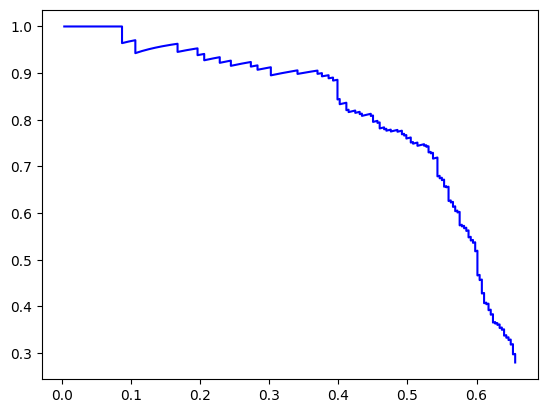

In [96]:
mrec = np.concatenate(([0.], recall, [min(recall[-1] + 1E-3, 1.)]))
mpre = np.concatenate(([0.], precision, [0.]))
mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

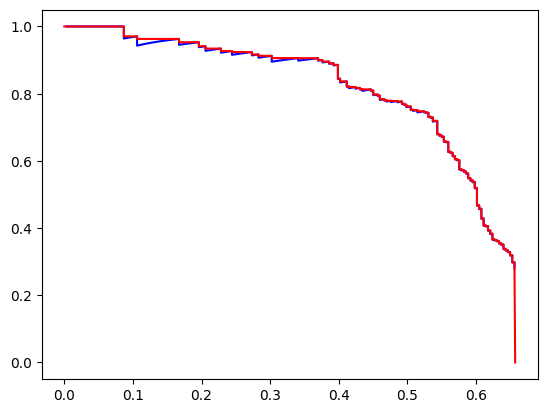

In [97]:
plt.plot(recall, precision, "b-")
plt.plot(mrec, mpre, "r-")

In [99]:
x = np.linspace(0,1,11)
average_precision = np.mean(np.interp(x, mrec, mpre))
class_name = label_map[compute_classes_index]
print(f"VOC2007 11point ap: Class {compute_classes_index:02d}[{ class_name:11s}] AP@{iou_threshold} = {average_precision:.3f}")

VOC2007 11point ap: Class 00[aeroplane  ] AP@0.5 = 0.541


In [100]:
x = np.linspace(0, 1, 101)
average_precision = np.mean(np.interp(x, mrec, mpre))
class_name = label_map[compute_classes_index]
print(f"VOC2007 11point ap: Class {compute_classes_index:02d}[{ class_name:11s}] AP@{iou_threshold} = {average_precision:.3f}")

VOC2007 11point ap: Class 00[aeroplane  ] AP@0.5 = 0.545


In [3]:
import sys
sys.path.append('..')

In [4]:
from evaluate.evaluation import MAPTool

In [5]:
label_map = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
map = MAPTool(label_map)
map.cal_map(groundtruth_annotations,detection_annotations)

Average Precision  (AP) @[ IoU=0.5      | area=   all | maxDets=100 ] = 0.509
Average Precision  (AP) @[ IoU=0.75     | area=   all | maxDets=100 ] = 0.262
Average Precision  (AP) @[ IoU=0.5:0.95 | area=   all | maxDets=100 ] = 0.271
Class 00[aeroplane  ] mAP@.5 = 0.545,  mAP@.75 = 0.130,  mAP@.5:.95 = 0.234
Class 01[bicycle    ] mAP@.5 = 0.623,  mAP@.75 = 0.371,  mAP@.5:.95 = 0.362
Class 02[bird       ] mAP@.5 = 0.366,  mAP@.75 = 0.118,  mAP@.5:.95 = 0.173
Class 03[boat       ] mAP@.5 = 0.325,  mAP@.75 = 0.087,  mAP@.5:.95 = 0.125
Class 04[bottle     ] mAP@.5 = 0.301,  mAP@.75 = 0.087,  mAP@.5:.95 = 0.132
Class 05[bus        ] mAP@.5 = 0.596,  mAP@.75 = 0.492,  mAP@.5:.95 = 0.394
Class 06[car        ] mAP@.5 = 0.679,  mAP@.75 = 0.462,  mAP@.5:.95 = 0.420
Class 07[cat        ] mAP@.5 = 0.583,  mAP@.75 = 0.388,  mAP@.5:.95 = 0.345
Class 08[chair      ] mAP@.5 = 0.286,  mAP@.75 = 0.112,  mAP@.5:.95 = 0.135
Class 09[cow        ] mAP@.5 = 0.388,  mAP@.75 = 0.164,  mAP@.5:.95 = 0.193
Class 

array([0.50891916, 0.26189371, 0.27058154])